In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm.notebook import tqdm
import numpy as np
from typing import NamedTuple
from itertools import chain

In [2]:
from policy_generator.policy_instances.envs.simple_arena import ActionSpace

In [20]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 1000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = 'cpu'

In [21]:
class ObsSpace(NamedTuple):
    agent: np.ndarray
    agent_direction: int
    target: np.ndarray
    velocity: int

In [22]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
#         self.input_layer = 
#         self.relu = nn.ReLU(32, 32)
#         self.output_layer = nn.Linear(32, action_space)
        self.model = nn.Sequential(
            nn.Linear(observation_space, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_space)
        )
    
    #forward pass
    def forward(self, x):
        #input states
#         x = self.input_layer(x)
        
#         #relu activation
#         x = F.relu(x)
        
#         #actions
#         actions = self.output_layer(x)
        actions = self.model(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        # print(action_probs)
        
        return action_probs

In [23]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = ObsSpace(**state[0] if isinstance(state, tuple) else state)
    unpack_state = list(chain(state.agent, state.target, [state.velocity, state.agent_direction]))
    state = torch.Tensor(unpack_state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    # print(m, action)
    
    #return action
    return action.item(), m.log_prob(action)

In [27]:
#Make environment
env = gym.make("policy_instances/SimpleArena-v0")

#Init network
network = PolicyNetwork(env.shape, env.action_space.n).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-4)

In [28]:
state = env.reset()
select_action(network, state)

(4, tensor([-0.0409], device='cuda:0', grad_fn=<SqueezeBackward1>))

In [29]:
#track scores
scores = []

#iterate through episodes
for episode in tqdm(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    rewards = []
    log_probs = []
    score = 0
    
    #generate episode
    for step in range(MAX_STEPS):
        env.render()
        
        #select action
        action, lp = select_action(network, state)
        
        #execute action
        new_state, reward, done, _, _ = env.step(action)
        
        #track episode score
        score += reward
        
        #store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)
        
        #end episode
        if done:
            break
        
        #move into new state
        state = new_state
    
    #append score
    scores.append(score)
    print('Score:', score)
        
    #Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []
    
    #track cumulative reward
    total_r = .0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        # print(type(r), type(total_r), type(DISCOUNT_FACTOR), type(total_r ** DISCOUNT_FACTOR))
        # print(r, total_r, DISCOUNT_FACTOR, total_r ** DISCOUNT_FACTOR)
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        if total_r < 0:
            total_r = r - np.abs(total_r) ** DISCOUNT_FACTOR
        else:
            total_r = r + total_r ** DISCOUNT_FACTOR
        
        #append to discounted rewards
        discounted_rewards.append(total_r)
    
    #reverse discounted rewards
    rewards = torch.tensor(discounted_rewards).to(DEVICE)
    rewards = torch.flip(rewards, [0])
    
    #adjusting policy parameters with gradient ascent
    loss = []
    for r, lp in zip(rewards, log_probs):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * lp)
    
        
    #Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    print('Loss:', sum(loss))
    optimizer.step()

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Score: -1427
Loss: tensor([-15084.5156], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1387
Loss: tensor([-14812.9551], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1435
Loss: tensor([-16015.7812], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1402
Loss: tensor([-15395.8809], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1382
Loss: tensor([-19902.1113], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1357
Loss: tensor([-23167.8984], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1398
Loss: tensor([-17410.2949], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1368
Loss: tensor([-15631.7871], device='cuda:0', grad_fn=<AddBackward0>)
Score: -199
Loss: tensor([-3132.3923], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1384
Loss: tensor([-16488.7676], device='cuda:0', grad_fn=<AddBackward0>)
Score: -232
Loss: tensor([-2675.3257], device='cuda:0', grad_fn=<AddBackward0>)
Score: -501
Loss: tensor([-4684.2578], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1382
Loss: ten

Score: -1085
Loss: tensor([-38287.3867], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1061
Loss: tensor([-39059.2070], device='cuda:0', grad_fn=<AddBackward0>)
Score: 3
Loss: tensor([534.4512], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1082
Loss: tensor([-37101.2148], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1055
Loss: tensor([-36262.1289], device='cuda:0', grad_fn=<AddBackward0>)
Score: -158
Loss: tensor([-5600.4116], device='cuda:0', grad_fn=<AddBackward0>)
Score: -995
Loss: tensor([-35572.2617], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1099
Loss: tensor([-37568.1211], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1042
Loss: tensor([-36622.7539], device='cuda:0', grad_fn=<AddBackward0>)
Score: -923
Loss: tensor([-31244.2598], device='cuda:0', grad_fn=<AddBackward0>)
Score: -959
Loss: tensor([-32000.4355], device='cuda:0', grad_fn=<AddBackward0>)
Score: -966
Loss: tensor([-33249.5039], device='cuda:0', grad_fn=<AddBackward0>)
Score: -1068
Loss: tensor([-3

Score: -805
Loss: tensor([-23795.7812], device='cuda:0', grad_fn=<AddBackward0>)
Score: -751
Loss: tensor([-21226.8203], device='cuda:0', grad_fn=<AddBackward0>)
Score: -801
Loss: tensor([-24749.8418], device='cuda:0', grad_fn=<AddBackward0>)
Score: 28
Loss: tensor([150.5853], device='cuda:0', grad_fn=<AddBackward0>)
Score: -812
Loss: tensor([-23153.], device='cuda:0', grad_fn=<AddBackward0>)
Score: -20
Loss: tensor([-432.5220], device='cuda:0', grad_fn=<AddBackward0>)
Score: -12
Loss: tensor([-18.4089], device='cuda:0', grad_fn=<AddBackward0>)
Score: -939
Loss: tensor([-29595.1426], device='cuda:0', grad_fn=<AddBackward0>)
Score: -773
Loss: tensor([-23888.8418], device='cuda:0', grad_fn=<AddBackward0>)
Score: -832
Loss: tensor([-23300.6660], device='cuda:0', grad_fn=<AddBackward0>)
Score: -798
Loss: tensor([-24997.9043], device='cuda:0', grad_fn=<AddBackward0>)
Score: -102
Loss: tensor([-2970.8291], device='cuda:0', grad_fn=<AddBackward0>)
Score: -749
Loss: tensor([-22082.1719], devic

Score: -768
Loss: tensor([-21404.5156], device='cuda:0', grad_fn=<AddBackward0>)
Score: -804
Loss: tensor([-22428.6465], device='cuda:0', grad_fn=<AddBackward0>)
Score: -752
Loss: tensor([-21220.0449], device='cuda:0', grad_fn=<AddBackward0>)
Score: -678
Loss: tensor([-18779.2344], device='cuda:0', grad_fn=<AddBackward0>)
Score: -731
Loss: tensor([-21504.3926], device='cuda:0', grad_fn=<AddBackward0>)
Score: -754
Loss: tensor([-19329.9805], device='cuda:0', grad_fn=<AddBackward0>)
Score: -789
Loss: tensor([-21108.3770], device='cuda:0', grad_fn=<AddBackward0>)
Score: -813
Loss: tensor([-23338.9434], device='cuda:0', grad_fn=<AddBackward0>)
Score: -458
Loss: tensor([-13344.5322], device='cuda:0', grad_fn=<AddBackward0>)
Score: -681
Loss: tensor([-18415.4863], device='cuda:0', grad_fn=<AddBackward0>)
Score: -740
Loss: tensor([-20889.3281], device='cuda:0', grad_fn=<AddBackward0>)
Score: -245
Loss: tensor([-5888.0488], device='cuda:0', grad_fn=<AddBackward0>)
Score: -687
Loss: tensor([-17

Score: -230
Loss: tensor([-6118.9873], device='cuda:0', grad_fn=<AddBackward0>)
Score: -303
Loss: tensor([-8020.2422], device='cuda:0', grad_fn=<AddBackward0>)
Score: -658
Loss: tensor([-15579.5469], device='cuda:0', grad_fn=<AddBackward0>)
Score: -590
Loss: tensor([-16099.8018], device='cuda:0', grad_fn=<AddBackward0>)
Score: -242
Loss: tensor([-7747.9277], device='cuda:0', grad_fn=<AddBackward0>)
Score: -134
Loss: tensor([-3484.5774], device='cuda:0', grad_fn=<AddBackward0>)
Score: -769
Loss: tensor([-22557.6680], device='cuda:0', grad_fn=<AddBackward0>)
Score: -664
Loss: tensor([-16770.9160], device='cuda:0', grad_fn=<AddBackward0>)
Score: -127
Loss: tensor([-3113.9214], device='cuda:0', grad_fn=<AddBackward0>)
Score: -585
Loss: tensor([-13498.8623], device='cuda:0', grad_fn=<AddBackward0>)
Score: -732
Loss: tensor([-18714.2422], device='cuda:0', grad_fn=<AddBackward0>)
Score: -786
Loss: tensor([-23324.3340], device='cuda:0', grad_fn=<AddBackward0>)
Score: -665
Loss: tensor([-20871.

Score: -206
Loss: tensor([-4122.3115], device='cuda:0', grad_fn=<AddBackward0>)
Score: -260
Loss: tensor([-6537.0264], device='cuda:0', grad_fn=<AddBackward0>)
Score: -693
Loss: tensor([-17857.7598], device='cuda:0', grad_fn=<AddBackward0>)
Score: -615
Loss: tensor([-12685.8691], device='cuda:0', grad_fn=<AddBackward0>)
Score: -126
Loss: tensor([-2854.5095], device='cuda:0', grad_fn=<AddBackward0>)
Score: -216
Loss: tensor([-4746.5845], device='cuda:0', grad_fn=<AddBackward0>)
Score: -678
Loss: tensor([-15371.9658], device='cuda:0', grad_fn=<AddBackward0>)
Score: -632
Loss: tensor([-14955.7930], device='cuda:0', grad_fn=<AddBackward0>)
Score: -355
Loss: tensor([-8187.3989], device='cuda:0', grad_fn=<AddBackward0>)
Score: -630
Loss: tensor([-13260.6436], device='cuda:0', grad_fn=<AddBackward0>)
Score: -209
Loss: tensor([-4486.7012], device='cuda:0', grad_fn=<AddBackward0>)
Score: -675
Loss: tensor([-20971.2305], device='cuda:0', grad_fn=<AddBackward0>)
Score: -577
Loss: tensor([-13004.2

Score: -714
Loss: tensor([-19955.0059], device='cuda:0', grad_fn=<AddBackward0>)
Score: -709
Loss: tensor([-17219.8379], device='cuda:0', grad_fn=<AddBackward0>)
Score: -672
Loss: tensor([-17117.7715], device='cuda:0', grad_fn=<AddBackward0>)
Score: -681
Loss: tensor([-21340.1699], device='cuda:0', grad_fn=<AddBackward0>)
Score: -613
Loss: tensor([-11904.0420], device='cuda:0', grad_fn=<AddBackward0>)
Score: -657
Loss: tensor([-14145.8955], device='cuda:0', grad_fn=<AddBackward0>)
Score: -474
Loss: tensor([-9850.7852], device='cuda:0', grad_fn=<AddBackward0>)
Score: -623
Loss: tensor([-14223.9521], device='cuda:0', grad_fn=<AddBackward0>)
Score: -196
Loss: tensor([-4185.1699], device='cuda:0', grad_fn=<AddBackward0>)
Score: -382
Loss: tensor([-9512.4189], device='cuda:0', grad_fn=<AddBackward0>)
Score: -180
Loss: tensor([-3879.5620], device='cuda:0', grad_fn=<AddBackward0>)
Score: -316
Loss: tensor([-6080.0625], device='cuda:0', grad_fn=<AddBackward0>)
Score: -623
Loss: tensor([-15452.

Score: -438
Loss: tensor([-9342.2930], device='cuda:0', grad_fn=<AddBackward0>)
Score: -576
Loss: tensor([-10367.9258], device='cuda:0', grad_fn=<AddBackward0>)
Score: -677
Loss: tensor([-15158.2578], device='cuda:0', grad_fn=<AddBackward0>)
Score: -652
Loss: tensor([-19429.2812], device='cuda:0', grad_fn=<AddBackward0>)
Score: -347
Loss: tensor([-8677.2373], device='cuda:0', grad_fn=<AddBackward0>)
Score: 7
Loss: tensor([638.0736], device='cuda:0', grad_fn=<AddBackward0>)
Score: -590
Loss: tensor([-15976.0898], device='cuda:0', grad_fn=<AddBackward0>)
Score: -558
Loss: tensor([-10647.0391], device='cuda:0', grad_fn=<AddBackward0>)
Score: -623
Loss: tensor([-12619.8506], device='cuda:0', grad_fn=<AddBackward0>)
Score: -428
Loss: tensor([-12739.8213], device='cuda:0', grad_fn=<AddBackward0>)
Score: -561
Loss: tensor([-10248.0830], device='cuda:0', grad_fn=<AddBackward0>)
Score: -624
Loss: tensor([-18807.5898], device='cuda:0', grad_fn=<AddBackward0>)
Score: -588
Loss: tensor([-11846.527

Score: -390
Loss: tensor([-8428.1084], device='cuda:0', grad_fn=<AddBackward0>)
Score: -566
Loss: tensor([-15238.4102], device='cuda:0', grad_fn=<AddBackward0>)
Score: -590
Loss: tensor([-14975.9756], device='cuda:0', grad_fn=<AddBackward0>)
Score: -361
Loss: tensor([-6624.6631], device='cuda:0', grad_fn=<AddBackward0>)
Score: 19
Loss: tensor([-30.9644], device='cuda:0', grad_fn=<AddBackward0>)
Score: -769
Loss: tensor([-21469.7988], device='cuda:0', grad_fn=<AddBackward0>)
Score: -31
Loss: tensor([-408.8355], device='cuda:0', grad_fn=<AddBackward0>)
Score: -42
Loss: tensor([-436.6916], device='cuda:0', grad_fn=<AddBackward0>)
Score: -506
Loss: tensor([-13402.5381], device='cuda:0', grad_fn=<AddBackward0>)
Score: -527
Loss: tensor([-13408.1689], device='cuda:0', grad_fn=<AddBackward0>)
Score: -388
Loss: tensor([-7060.9072], device='cuda:0', grad_fn=<AddBackward0>)
Score: -574
Loss: tensor([-9132.8242], device='cuda:0', grad_fn=<AddBackward0>)
Score: -648
Loss: tensor([-16767.0156], dev

Loss: tensor([-6391.8599], device='cuda:0', grad_fn=<AddBackward0>)
Score: -174
Loss: tensor([-2804.2175], device='cuda:0', grad_fn=<AddBackward0>)
Score: -538
Loss: tensor([-6116.4653], device='cuda:0', grad_fn=<AddBackward0>)
Score: -609
Loss: tensor([-11939.4941], device='cuda:0', grad_fn=<AddBackward0>)
Score: -588
Loss: tensor([-9509.1133], device='cuda:0', grad_fn=<AddBackward0>)
Score: -610
Loss: tensor([-10319.4775], device='cuda:0', grad_fn=<AddBackward0>)
Score: -71
Loss: tensor([-1157.8807], device='cuda:0', grad_fn=<AddBackward0>)
Score: -604
Loss: tensor([-10980.4326], device='cuda:0', grad_fn=<AddBackward0>)
Score: -551
Loss: tensor([-10420.3271], device='cuda:0', grad_fn=<AddBackward0>)
Score: -626
Loss: tensor([-15869.0176], device='cuda:0', grad_fn=<AddBackward0>)
Score: -554
Loss: tensor([-7688.2700], device='cuda:0', grad_fn=<AddBackward0>)
Score: -92
Loss: tensor([-2014.3921], device='cuda:0', grad_fn=<AddBackward0>)
Score: -574
Loss: tensor([-7773.4390], device='cu

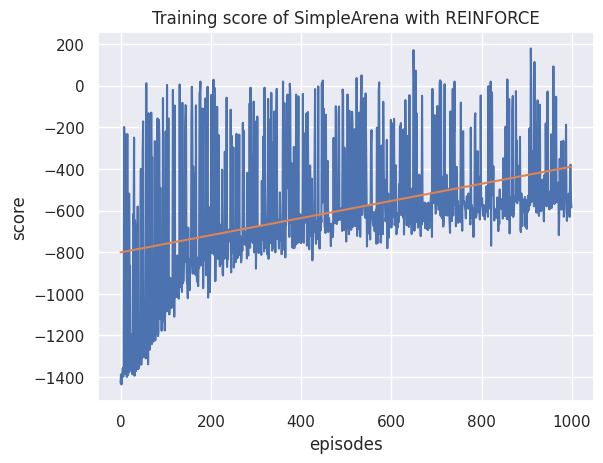

In [31]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of SimpleArena with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [32]:
done = False
state = env.reset()
scores = []

for _ in range(10):
    state = env.reset()
    done = False
    score = 0
    while not done:
        # env.render()
        action = env.action_space.sample()
        new_state, reward, done, info, _ = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

In [ ]:
done = False
state = env.reset()
scores = []

for _ in tqdm(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action, lp = select_action(network, state)
        new_state, reward, done, info, _ = env.step(action)
        # print(state, action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
np.array(scores).mean()